In [ ]:
# Import libraries
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import scipy.stats as stats

import re
import string

from imblearn.over_sampling import SMOTE

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC

from statsmodels.stats.multicomp import pairwise_tukeyhsd

from textblob import TextBlob

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import files
files=files.upload()

Saving mbti_1.csv to mbti_1.csv


In [ ]:
df = pd.read_csv('mbti_1.csv')

In [ ]:
df.shape

(8675, 2)

In [ ]:
print(df.iloc[0,1])

'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/uploads/2010/04/round-home-design.jpg ...|

In [ ]:
df.isnull().sum()

type     0
posts    0
dtype: int64

In [ ]:
df['type'].unique()

array(['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
       'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ'],
      dtype=object)

In [ ]:
df['type'].value_counts()


INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64

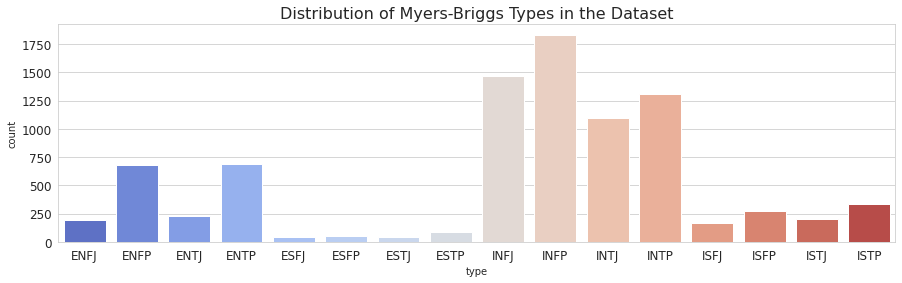

In [ ]:
dims1 = (15.0, 4.0)
fig, ax = plt.subplots(figsize=dims1)
coolwarm = sns.color_palette("coolwarm", 16)
sns.set_palette(coolwarm)
sns.countplot(x="type", data=df, \
              order=["ENFJ","ENFP","ENTJ","ENTP","ESFJ","ESFP","ESTJ","ESTP",\
                     "INFJ","INFP","INTJ","INTP","ISFJ","ISFP","ISTJ","ISTP"])
plt.title("Distribution of Myers-Briggs Types in the Dataset", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

In [ ]:
print('Introversion (I) – Extroversion (E)', '\n', df['type'].map(lambda x: x[0]).value_counts(), '\n')
print('Intuition (N) – Sensing (S)', '\n', df['type'].map(lambda x: x[1]).value_counts(), '\n')
print('Thinking (T) – Feeling (F)', '\n', df['type'].map(lambda x: x[2]).value_counts(), '\n')
print('Judging (J) – Perceiving (P)', '\n', df['type'].map(lambda x: x[3]).value_counts(), '\n')

Introversion (I) – Extroversion (E) 
 I    6676
E    1999
Name: type, dtype: int64 

Intuition (N) – Sensing (S) 
 N    7478
S    1197
Name: type, dtype: int64 

Thinking (T) – Feeling (F) 
 F    4694
T    3981
Name: type, dtype: int64 

Judging (J) – Perceiving (P) 
 P    5241
J    3434
Name: type, dtype: int64 



**Preprocessing**

In [ ]:
df_working = df.copy()
df_working.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [ ]:
df_working['I-E'] = df_working['type'].map(lambda x: 'Introversion' if x[0] == 'I' else 'Extroversion')
df_working['N-S'] = df_working['type'].map(lambda x: 'Intuition' if x[1] == 'N' else 'Sensing')
df_working['T-F'] = df_working['type'].map(lambda x: 'Thinking' if x[2] == 'T' else 'Feeling')
df_working['J-P'] = df_working['type'].map(lambda x: 'Judging' if x[3] == 'J' else 'Perceiving')

df_working.head()

,type,posts,I-E,N-S,T-F,J-P
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,Introversion,Intuition,Feeling,Judging
1,ENTP,'I'm finding the lack of me in these posts ver...,Extroversion,Intuition,Thinking,Perceiving
2,INTP,'Good one _____ https://www.youtube.com/wat...,Introversion,Intuition,Thinking,Perceiving
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",Introversion,Intuition,Thinking,Judging
4,ENTJ,'You're fired.|||That's another silly misconce...,Extroversion,Intuition,Thinking,Judging


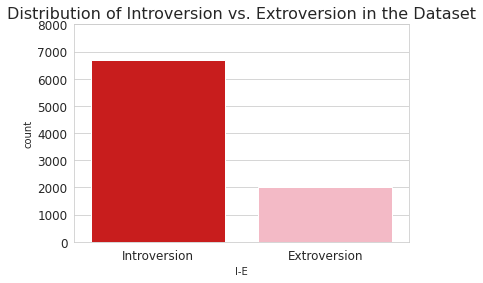

In [ ]:

# Countplot of Introversion - Extroversion axis
IEcolors = sns.xkcd_palette(["red", "soft pink"])
sns.set_palette(IEcolors)
sns.countplot(x="I-E", data=df_working, order=["Introversion", "Extroversion"])
plt.title("Distribution of Introversion vs. Extroversion in the Dataset", fontsize=16)
plt.ylim(0, 8000)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

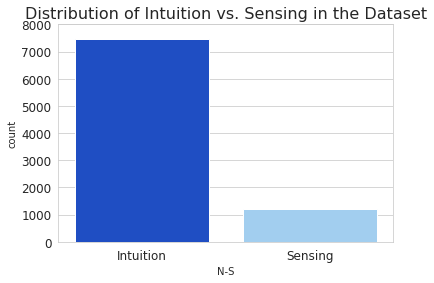

In [ ]:
NScolors = sns.xkcd_palette(["blue", "light blue"])
sns.set_palette(NScolors)
sns.countplot(x="N-S", data=df_working, order=["Intuition", "Sensing"])
plt.title("Distribution of Intuition vs. Sensing in the Dataset", fontsize=16)
plt.ylim(0, 8000)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

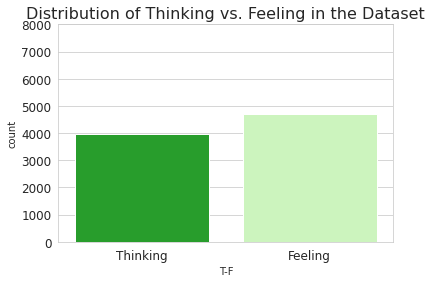

In [ ]:
TFcolors = sns.xkcd_palette(["green", "pale green"])
sns.set_palette(TFcolors)
sns.countplot(x="T-F", data=df_working, order=["Thinking", "Feeling"])
plt.title("Distribution of Thinking vs. Feeling in the Dataset", fontsize=16)
plt.ylim(0, 8000)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

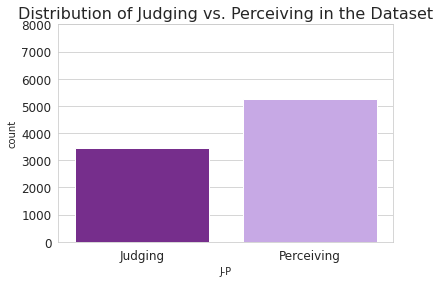

In [ ]:
JPcolors = sns.xkcd_palette(["purple", "lavender"])
sns.set_palette(JPcolors)
sns.countplot(x="J-P", data=df_working, order=["Judging", "Perceiving"])
plt.title("Distribution of Judging vs. Perceiving in the Dataset", fontsize=16)
plt.ylim(0, 8000)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

In [ ]:
posts = df_working['posts'].copy()
posts = posts.apply(lambda x: x.replace('|||', ' ')) # replaces post separators with empty space
posts.head()

0    'http://www.youtube.com/watch?v=qsXHcwe3krw ht...
1    'I'm finding the lack of me in these posts ver...
2    'Good one  _____   https://www.youtube.com/wat...
3    'Dear INTP,   I enjoyed our conversation the o...
4    'You're fired. That's another silly misconcept...
Name: posts, dtype: object

In [ ]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
types = ['infj', 'entp', 'intp', 'intj', 'entj', 'enfj', 'infp', 'enfp', 'isfp',
         'istp', 'isfj', 'istj', 'estp', 'esfp', 'estj', 'esfj']
stop = stopwords.words('english')

for type in types:
    stop.append(type)
stop.append("url")
stop_rev = stop    
print(stop_rev)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
def cleaner(text):
    stemmer=PorterStemmer()                                      
    text = text.replace('|||', ' ')                                  
    text = re.sub(r'\bhttps?:\/\/.*?[\r\n]*? ', 'URL ', text, flags=re.MULTILINE)  
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.translate(str.maketrans('', '', string.digits))      
    text = text.lower().strip()                                      
    final_text = []
    for w in text.split():
        if w not in stop:
            final_text.append(stemmer.stem(w.strip()))
    return ' '.join(final_text)

In [ ]:
df.posts.iloc[0]

"'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/uploads/2010/04/round-home-design.jpg ...

In [ ]:
cleaner(df.posts.iloc[0])

'moment sportscent top ten play prank lifechang experi life repeat today may perc experi immers last thing friend post facebook commit suicid next day rest peac hello sorri hear distress natur relationship perfect time everi moment exist tri figur hard time time growth welcom stuff game set match prozac wellbrutin least thirti minut move leg dont mean move sit desk chair weed moder mayb tri edibl healthier altern basic come three item youv determin type whichev type want would like use given type cognit function whatnot left thing moder sim inde video game good one note good one somewhat subject complet promot death given sim dear favorit video game grow current favorit video game cool appear late sad there someon everyon wait thought confid good thing cherish time solitud bc revel within inner world wherea time id workin enjoy time dont worri peopl alway around yo ladi your complimentari personalitywel hey main social outlet xbox live convers even verbal fatigu quickli realli dig part

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
cv = TfidfVectorizer(preprocessor=cleaner, stop_words=stop_rev, ngram_range=(1,2), max_features=1000)
cv.fit_transform(posts)

cv.transform(posts).todense()
df_posts = pd.DataFrame(cv.transform(posts).todense(), 
             columns=cv.get_feature_names())
df_posts.head()


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['arent', 'couldnt', 'didnt', 'doesnt', 'dont', 'hadnt', 'hasnt', 'havent', 'isnt', 'mightnt', 'mustnt', 'neednt', 'shant', 'shouldnt', 'shouldv', 'thatll', 'wasnt', 'werent', 'wont', 'wouldnt', 'youd', 'youll', 'youv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


,abil,abl,absolut,accept,account,accur,across,act,action,activ,actual,add,admit,advic,affect,afraid,age,ago,agre,ah,allow,almost,alon,along,alreadi,also,although,alway,amaz,amount,angri,anim,annoy,anoth,answer,answer question,anxieti,anymor,anyon,anyon els,...,win,wink,wish,within,without,woman,women,wonder,wont,word,work,world,worri,wors,worst,worth,would,would like,would say,wouldnt,wow,write,written,wrong,wrote,xd,ye,yeah,year,year ago,year old,yep,yesterday,yet,youd,youll,young,younger,youtub,youv
0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.065257,0.055776,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.034277,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.082461,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.088824,0.067600,0.0,0.000000,0.00000,0.029328,0.072676,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.037492,0.075113,0.000000,0.091883,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.066060
1,0.000000,0.035780,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.052075,0.041318,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.034615,0.062900,0.0,0.042963,0.000000,0.0,0.000000,0.044165,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.038363,0.030008,0.065598,0.000000,0.000000,0.0,0.052153,0.00000,0.073520,0.000000,0.000000,0.033959,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.023496,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
2,0.134089,0.048485,0.108886,0.000000,0.0,0.067243,0.0,0.0,0.000000,0.0,0.061743,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.046905,0.000000,0.0,0.087327,0.061394,0.0,0.066902,0.059846,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.048938,0.000000,0.00000,0.000000,0.058983,0.04291,0.000000,0.081327,0.118519,0.037716,0.000000,0.0,0.000000,0.00000,0.049812,0.000000,0.000000,0.046017,0.000000,0.045845,0.000000,0.000000,0.0,0.000000,0.033160,0.000000,0.127357,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
3,0.000000,0.068667,0.038552,0.041127,0.0,0.000000,0.0,0.0,0.090761,0.0,0.065583,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.027085,0.0,0.0,0.03252,0.035136,0.0,0.066430,0.080474,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.039972,0.028698,0.030421,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.034654,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.020981,0.000000,0.040652,0.0,0.000000,0.00000,0.070547,0.000000,0.044217,0.000000,0.121705,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.028372,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.044659,0.0,0.0,0.0,0.079451
4,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.024555,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.022598,0.0,0.023153,0.000000,0.0,0.000000,0.000000,0.044898,0.032235,0.034170,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.03405,0.053327,0.000000,0.00000,0.000000,0.000000,0.023567,0.000000,0.000000,0.0,0.000000,0.05317,0.099051,0.000000,0.000000,0.036602,0.000000,0.000000,0.059002,0.035143,0.0,0.056978,0.052751,0.000000,0.025325,0.000000,0.057365,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000


In [ ]:
df_posts.shape

(8675, 1000)

In [ ]:
print(df_posts.sum().sort_values(ascending=False).head(10))

im        1265.769936
like      1155.477329
think      891.134800
dont       818.336254
peopl      751.443689
one        628.374461
know       620.878488
get        617.492215
feel       605.201579
realli     573.758069
dtype: float64


In [ ]:

with pd.option_context('display.max_rows', 1, 'display.max_columns', None):
    print(df_posts)

    abil  abl  absolut  accept  account  accur  across  act  action  activ  \
0    0.0  0.0      0.0     0.0      0.0    0.0     0.0  0.0     0.0    0.0   
..   ...  ...      ...     ...      ...    ...     ...  ...     ...    ...   

    actual  add  admit  advic  affect  afraid       age       ago  agre   ah  \
0      0.0  0.0    0.0    0.0     0.0     0.0  0.065257  0.055776   0.0  0.0   
..     ...  ...    ...    ...     ...     ...       ...       ...   ...  ...   

    allow  almost  alon  along  alreadi  also  although     alway  amaz  \
0     0.0     0.0   0.0    0.0      0.0   0.0       0.0  0.034277   0.0   
..    ...     ...   ...    ...      ...   ...       ...       ...   ...   

    amount  angri  anim  annoy  anoth  answer  answer question  anxieti  \
0      0.0    0.0   0.0    0.0    0.0     0.0              0.0      0.0   
..     ...    ...   ...    ...    ...     ...              ...      ...   

    anymor  anyon  anyon els  anyth  anyway  apart  apolog  appar    app

Classification

In [ ]:
baseline = df['type'].value_counts().max() / df['type'].value_counts().sum()
baseline

0.21118155619596543

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_posts,
                                                   df['type'].values,
                                                   test_size=0.30, random_state=42)
print('X_train ', X_train.shape, '\n', 'X_test ', X_test.shape, '\n', 'y_train ', y_train.shape, '\n', 
      'y_test', y_test.shape)

In [ ]:
cv = TfidfVectorizer(preprocessor=cleaner, stop_words=stop_rev, ngram_range=(1,2), max_features=1000)
cv.fit(X_train)
X_train_cv = cv.transform(X_train)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['arent', 'couldnt', 'didnt', 'doesnt', 'dont', 'hadnt', 'hasnt', 'havent', 'isnt', 'mightnt', 'mustnt', 'neednt', 'shant', 'shouldnt', 'shouldv', 'thatll', 'wasnt', 'werent', 'wont', 'wouldnt', 'youd', 'youll', 'youv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


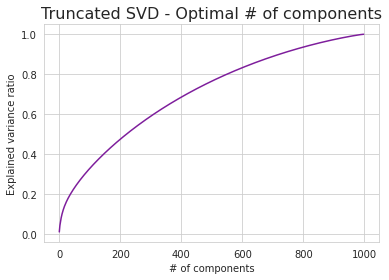

In [ ]:
tsvd = TruncatedSVD(n_components=999)
tsvd.fit(X_train_cv)
plt.plot(range(999), tsvd.explained_variance_ratio_.cumsum())
plt.title("Truncated SVD - Optimal # of components", fontsize=16)
plt.xlabel("# of components")
plt.ylabel("Explained variance ratio");

In [ ]:
from sklearn.cluster import MiniBatchKMeans

In [ ]:
kmeans=MiniBatchKMeans(n_clusters=10,random_state=0,batch_size=100,max_iter=100).fit(df_posts)

In [ ]:
one=kmeans.cluster_centers_[1]

In [ ]:
one.shape

(1000,)

In [ ]:
kmeans_inertia

5644.317219731087

In [ ]:
kmeans_kwargs = {
   ...:     "init": "random",
   ...:     "n_init": 10,
   ...:     "max_iter": 100,
   ...:     "random_state": 0,
   ...: }
   ...:
   ...: sse = []
   ...: for k in range(1, 100):
   ...:     kmeans = MiniBatchKMeans(n_clusters=k,batch_size=100, **kmeans_kwargs).fit(df_posts)
   ...:     sse.append(kmeans.inertia_)

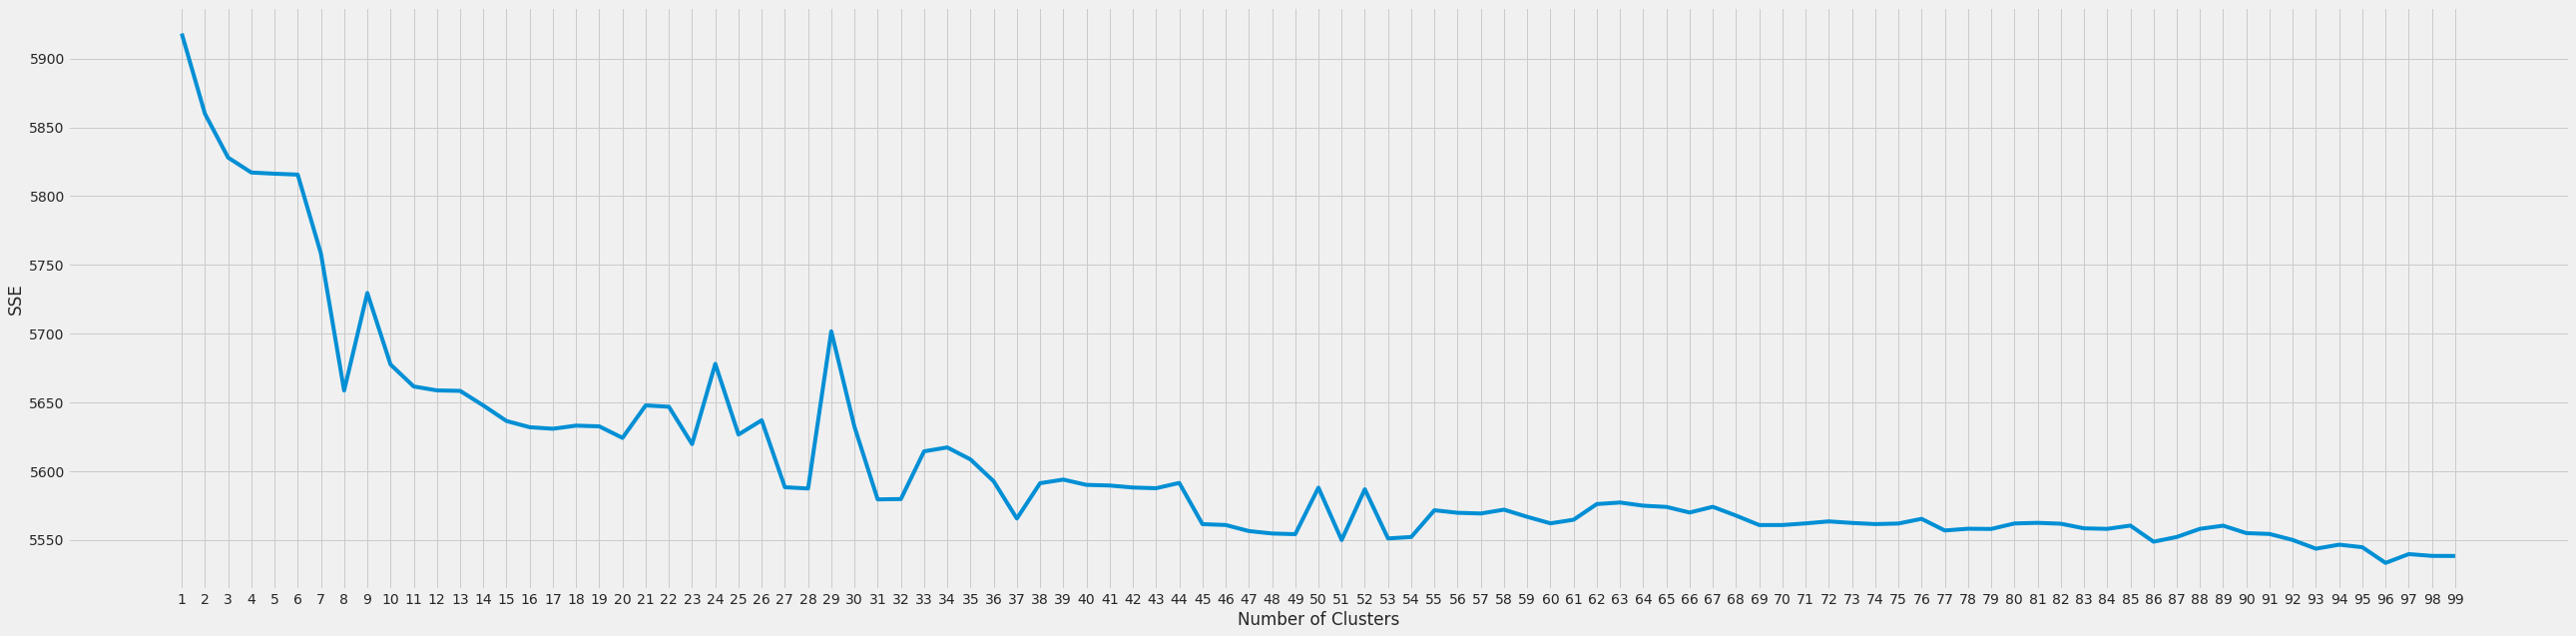

In [ ]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

ideal K value must be 37.